### Import libraries

In [1]:
from libs.Dataset import TripletTrashbinDataModule
from libs.Model import TripletNetwork, evaluating_performance
from torchvision.models import squeezenet1_1
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import progress
import warnings # or to ignore all warnings that could be false positives
warnings.filterwarnings("ignore")
from pytorch_lightning.utilities.warnings import PossibleUserWarning
warnings.filterwarnings("ignore", category=PossibleUserWarning)

In [2]:
class_dict = {
    0: 'empty',
    1: 'half',
    2: 'full'
}

data_img_size = 224
data_batch_size = 256
# otherwise, return warning
n_workers = 0  # os.cpu_count()

Load del dataModule

In [3]:
dm = TripletTrashbinDataModule(img_size=data_img_size,num_workers=n_workers)
dm.setup()

Loading squeezeNet

In [4]:
squeezeNet = squeezenet1_1(pretrained=True)
squeezeNet.classifier = nn.Identity()

Dimensione delle feature richieste dal modello <b>TODO: scrivi meglio</b>

In [5]:
squeezeNet(torch.zeros(1,3,data_img_size,data_img_size)).shape

torch.Size([1, 86528])

### Finding best parameters

Dato che il modello è lo stesso e cambia solo la loss, non ho la necessità di reiterare il find del learning rate con la loss cambiata

In [6]:
# parto dal LR trovato nel precedente report
tripletNetwork = TripletNetwork(squeezeNet, lr=0.002, batch_size=data_batch_size)

Utilizzando le funzioni di libreria di pytorch_lighting controllo la dimensione del batch <b>SCRIVI MEGLIO</b>

In [7]:
trainer = pl.Trainer(auto_scale_batch_size="power", max_epochs=-1)
trainer.tune(tripletNetwork, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Batch size 2 succeeded, trying batch size 4
Batch size 4 succeeded, trying batch size 8
Batch size 8 succeeded, trying batch size 16
Batch size 16 succeeded, trying batch size 32
Batch size 32 succeeded, trying batch size 64
Batch size 64 succeeded, trying batch size 128
Batch size 128 succeeded, trying batch size 256
Batch size 256 succeeded, trying batch size 512
Batch size 512 succeeded, trying batch size 1024
Batch size 1024 succeeded, trying batch size 2048
Batch size 2048 succeeded, trying batch size 4096
Batch size 4096 succeeded, trying batch size 8192
Batch size 6600 succeeded, trying batch size 13200
Finished batch size finder, will continue with full run using batch size 6600
Restoring states from the checkpoint path at /Users/danilo/GitHub/deep-learning/.scale_batch_size_cd046314-3d33-42b7-8bb2-55d987f7354e.ckpt


{'scale_batch_size': 6600}

Utilizzando la funzione di libreria di pytorch lighting vedo qual è il migliore LR <b>SCRIVI MEGLIO</b>

In [7]:
trainer = pl.Trainer(auto_lr_find=True)
lr_finder = trainer.tune(tripletNetwork, datamodule=dm)
lr_finder

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 50 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/danilo/GitHub/triplet-trashbin-classifier/.lr_find_d07c4002-f70a-49de-bfd2-97a2aa460a37.ckpt
Learning rate set to 7.585775750291837e-08


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x139b93940>}

### Test with different loss

Valuto le performance prima del training

In [6]:
# triplet margin loss
tripletNetwork_tml = TripletNetwork(squeezeNet, lr=7.585775750291837e-08, batch_size=data_batch_size)

100%|██████████| 124/124 [09:56<00:00,  4.81s/it]


Classification error 76.51143705355429


100%|██████████| 124/124 [09:11<00:00,  4.44s/it]


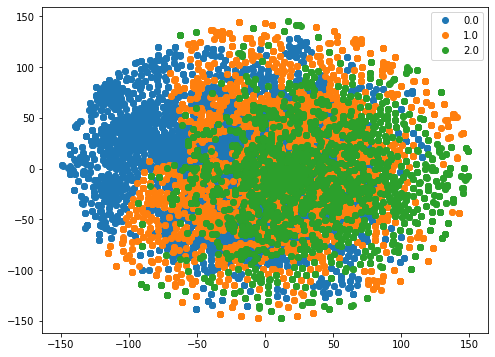

In [8]:
evaluating_performance(tripletNetwork_tml, dm)

Alleno il modello per 10 epoche con loss A

In [9]:
# TODO: potresti scrivere che questa cella del training è stata eseguita come script per comodità,
# quindi questa parte ti occupi solo di caricare il modello dal checkpoint. Le epoche le metti uguali cosi devi solo loggare

logger_tml = TensorBoardLogger("models/logs", name="tripletNetwork_TripletMarginLoss")

trainer = pl.Trainer(gpus=0,
                    max_epochs=11,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger_tml,
                    accelerator="auto",
                    )

trainer.fit(model=tripletNetwork_tml, datamodule=dm)
trainer.save_checkpoint('models/tripletNetwork_TripletMarginLoss_v0.ckpt')
torch.save(trainer.model.state_dict(), 'models/tripletNetwork_TripletMarginLoss_v0.pth')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: models/logs/tripletNetwork_TripletMarginLoss

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | SqueezeNet        | 722 K 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
722 K     Trainable params
0         Non-trainable params
722 K     Total params
2.890     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Valuto le performance ottenute

In [ ]:
evaluating_performance(tripletNetwork_tml, dm)

In [ ]:
# TODO: Aggiungi validazione di entrambe le reti

# model = TripletNetworkTask(squeezeNet, lr=7.585775750291837e-08, batch_size=data_batch_size) # parto dal LR trovato nel precedente studio
# trainer = pl.Trainer(gpus=0,)
# trainer.validate(model, datamodule=dm, ckpt_path="models/logs/triplet_squeezeNet_v1/version_2/checkpoints/epoch=30-step=6417.ckpt")

Effettuo le stesse prove con triplet margin loss with distance

In [10]:
tripletNetwork_tmwdl = TripletNetwork(squeezeNet, lr=7.585775750291837e-08, batch_size=data_batch_size, criterion=nn.TripletMarginWithDistanceLoss(margin=2, distance_function= nn.PairwiseDistance()))

100%|██████████| 124/124 [09:21<00:00,  4.52s/it]


Classification error 76.52450587883597


100%|██████████| 124/124 [09:14<00:00,  4.47s/it]


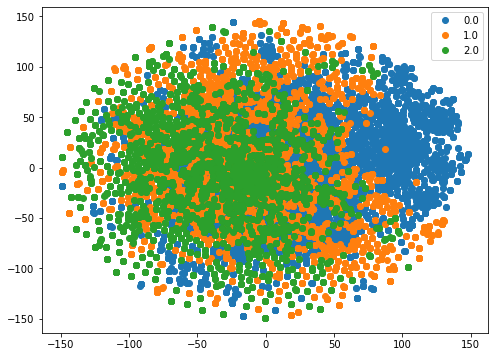

In [12]:
evaluating_performance(tripletNetwork_tmwdl, dm)

In [ ]:
# TODO: potresti scrivere che questa cella del training è stata eseguita come script per comodità,
# quindi questa parte ti occupi solo di caricare il modello dal checkpoint. Le epoche le metti uguali cosi devi solo loggare

logger_tmwdl = TensorBoardLogger("models/logs", name="tripletNetwork_TripletMarginWithDistanceLoss")

trainer = pl.Trainer(gpus=0,
                    max_epochs=11,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger_tmwdl,
                    accelerator="auto",
                    )

trainer.fit(model=tripletNetwork_tmwdl, datamodule=dm)
trainer.save_checkpoint('models/tripletNetwork_TripletMarginWithDistanceLoss_v0.ckpt')
torch.save(trainer.model.state_dict(), 'models/tripletNetwork_TripletMarginWithDistanceLoss_v0.pth')

In [ ]:
evaluating_performance(tripletNetwork_tmwdl, dm, data_batch_size)

In [ ]:
# TODO: Aggiungi validazione di entrambe le reti

# model = TripletNetworkTask(squeezeNet, lr=7.585775750291837e-08, batch_size=data_batch_size) # parto dal LR trovato nel precedente studio
# trainer = pl.Trainer(gpus=0,)
# trainer.validate(model, datamodule=dm, ckpt_path="models/logs/triplet_squeezeNet_v1/version_2/checkpoints/epoch=30-step=6417.ckpt")